In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import matplotlib.colors as colors
import multiprocessing
import warnings

from nanonets.utils import BLUE_COLOR, RED_COLOR, get_net_currents, create_weighted_undirected_graph, display_net_flow_graph
from nanonets import Simulation
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull, KDTree
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
from tqdm import tqdm
from scipy.optimize import curve_fit

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="seaborn"
)

plt.style.use(["science","bright","grid"])

PATH    = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq_size/"
PATH_R  = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/res_disorder/"

In [ ]:
def extract_harmonic_features(y_val, n_vals, N_periods=20, search_range=3, mode='complex', pad_len=None, interpolate=True):
    """
    Extracts harmonic features from a time series using FFT with optional zero-padding
    and parabolic interpolation for high-precision peak estimation.

    Parameters
    ----------
    y_val : array-like
        Input time series (e.g., current or voltage).
    n_vals : list or array-like of int
        List of harmonic orders to extract (e.g., [1, 2, 3] or [3, 5, 7]).
    N_periods : float, optional (default=20)
        Number of full periods of the fundamental frequency contained in y_val.
        Used to identify the theoretical FFT bin index of the fundamental.
    search_range : int, optional (default=3)
        Number of FFT bins to search left/right of the ideal index to account for 
        spectral leakage or small frequency deviations.
    mode : str, optional (default='complex')
        Format of the output features:
        - 'complex':   [Re, Im] pairs relative to fundamental phase. (Length = 2 * len(n_vals))
                       Preserves full shape info; ideal for Volumetric analysis.
        - 'abs':       [Magnitude] only. (Length = len(n_vals))
                       Ideal for THD or Centroid analysis.
        - 'projected': [Magnitude * cos(delta_phi)]. (Length = len(n_vals))
                       Scalar projection onto fundamental axis (lossy).
        - 'phase':     [Phase Difference] in normalized radians/pi [-1, 1].
    pad_len : int or None, optional (default=None)
        Length of the FFT padding. If None, uses len(y_val). 
        Higher values (e.g., 4096) increase spectral density, reducing discretization error.
    interpolate : bool, optional (default=True)
        If True, uses parabolic interpolation on the spectral peak to estimate 
        magnitude and frequency more accurately than the discrete FFT bin resolution.
        Recommended to avoid "bimodality" in error distributions.

    Returns
    -------
    np.ndarray
        Array of feature values. Structure and length depend on 'mode'.
    """
    
    # --- 1. Preprocessing: Detrend and Window ---
    y_val = np.array(y_val)
    # Remove DC offset to prevent 0-Hz peak leakage
    y_val = y_val - np.mean(y_val)
    
    N_samples = len(y_val)
    
    # Blackman window minimizes spectral leakage (low sidelobes)
    window = np.blackman(N_samples)
    y_windowed = y_val * window
    
    # Coherent Gain Correction: compensates for energy amplitude lost due to windowing
    w_gain = np.sum(window) / N_samples
    
    # --- 2. FFT Calculation ---
    # Determine padding
    if pad_len is None:
        n_fft = N_samples
        pad_ratio = 1.0
    else:
        n_fft = pad_len
        pad_ratio = n_fft / N_samples
    
    # rfft is efficient for real-valued inputs; returns positive freqs only
    fft_vals = np.fft.rfft(y_windowed, n=n_fft)

    # Helper: Peak Extraction Logic
    def get_peak_metrics(neighborhood):
        """
        Internal helper to find peak magnitude and phase from a spectral slice.
        Handles both discrete argmax and parabolic interpolation.
        """
        # Safety check for empty or zero-signal neighborhoods
        if len(neighborhood) == 0 or np.max(np.abs(neighborhood)) < 1e-15:
            return 0.0, 0.0

        # Magnitude spectrum of the neighborhood
        mags = np.abs(neighborhood)
        idx_local = np.argmax(mags)
        
        # 1. Discrete Estimates (Base)
        mag_peak = mags[idx_local]
        # Phase at the discrete peak bin
        phase_peak = np.angle(neighborhood[idx_local])
        
        # 2. Parabolic Interpolation (Refinement)
        if interpolate:
            # We need 3 points: (left, center, right)
            # Check bounds to ensure we have neighbors
            if 0 < idx_local < len(mags) - 1:
                alpha = mags[idx_local - 1]
                beta  = mags[idx_local]
                gamma = mags[idx_local + 1]
                
                # Calculate fractional peak shift 'delta' (-0.5 to 0.5)
                # Formula: Parabolic peak location
                denominator = (alpha - 2 * beta + gamma)
                if denominator != 0:
                    delta = 0.5 * (alpha - gamma) / denominator
                    
                    # Refined Magnitude Estimate
                    mag_peak = beta - 0.25 * (alpha - gamma) * delta
                    
                    # Optional: We stick to the discrete bin phase for robustness, 
                    # but the magnitude is now "physics-accurate".

        return mag_peak, phase_peak

    # --- 3. Find Fundamental Phase (Reference Frame) ---
    k_fund_ideal = int(round(1.0 * N_periods * pad_ratio))
    
    # Define search window (scaled by pad_ratio)
    s_width = int(search_range * pad_ratio)
    f_start = max(0, k_fund_ideal - s_width)
    f_end   = min(len(fft_vals), k_fund_ideal + s_width + 1)
    
    fund_neighborhood = fft_vals[f_start:f_end]
    
    # Get Fundamental Metrics
    amp_fund_raw, phi_1 = get_peak_metrics(fund_neighborhood)
    
    # Note: amp_fund_raw is currently in "FFT units". 
    # We don't convert it to physical units yet because we only need phi_1 here.
    # (Though for consistency, it's good to know amp_fund is available).

    features = []

    # Scaling Factor: Convert FFT amplitude to Physical Amplitude
    #   * 2.0: Accounts for negative frequencies dropped by rfft
    #   * / N_samples: Normalization by original signal length (not padded length)
    #   * / w_gain: Correction for window attenuation
    phys_scale = (2.0 / N_samples) / w_gain

    # --- 4. Extract Harmonics ---
    for m in n_vals:
        # Ideal bin for m-th harmonic
        k_ideal = int(round(m * N_periods * pad_ratio))
        
        # Search window
        start = max(0, k_ideal - s_width)
        end   = min(len(fft_vals), k_ideal + s_width + 1)
        
        # Check if harmonic is within Nyquist limit
        if start < len(fft_vals) and start < end:
            neighborhood = fft_vals[start:end]
            
            # Get Harmonic Metrics
            mag_raw, phi_m = get_peak_metrics(neighborhood)
            
            # Convert to Physical Magnitude
            mag = mag_raw * phys_scale
            
            # Phase relative to fundamental (Shift Invariant)
            delta_phi = phi_m - (m * phi_1)
            
            # --- Feature Formatting ---
            if mode == 'complex':
                # Map to 2D plane: (x, y) coordinates
                features.append(mag * np.cos(delta_phi))
                features.append(mag * np.sin(delta_phi))

            elif mode == 'phase':
                # Normalized Wrapped Phase [-1, 1]
                wrapped = (delta_phi + np.pi) % (2 * np.pi) - np.pi
                features.append(wrapped / np.pi)
                
            elif mode == 'projected':
                # Scalar projection onto Real axis
                features.append(mag * np.cos(delta_phi))
                
            else: # mode == 'abs'
                # Pure Magnitude
                features.append(mag)
                
        else:
            # Handle out-of-bounds (e.g., frequencies > Nyquist)
            if mode == 'complex':
                features.extend([0.0, 0.0])
            else:
                features.append(0.0)
                
    return np.array(features)

def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

def get_frequency_spectrum(signal, dt, pad_len=None):
    """
    Computes the calibrated one-sided amplitude spectrum with optional zero-padding.

    Parameters
    ----------
    signal : 1D numpy array
        Time-domain signal
    dt : float
        Time step in seconds
    pad_len : int or None, optional
        FFT length after zero-padding. If None, no padding is applied.

    Returns
    -------
    freqs : np.ndarray
        Frequency axis [Hz]
    amplitudes : np.ndarray
        Physical one-sided amplitude spectrum
    """
    signal = np.asarray(signal)
    N_samples = len(signal)

    # --- 1. Detrend & Window ---
    signal = signal - np.mean(signal)

    window = np.blackman(N_samples)
    signal_windowed = signal * window

    # Coherent gain correction
    w_gain = np.sum(window) / N_samples

    # --- 2. FFT length (padding-aware) ---
    if pad_len is None:
        n_fft = N_samples
    else:
        n_fft = pad_len

    fft_vals = np.fft.rfft(signal_windowed, n=n_fft)
    freqs = np.fft.rfftfreq(n_fft, dt)
    
    # --- 3. Amplitude Normalization ---
    amplitudes = (2.0 / N_samples) * np.abs(fft_vals) / w_gain
    
    return freqs, amplitudes

In [ ]:
N_PARTICLES     = [3,5,7,9,11,13]
N_PERIODS       = 100
SAMPLE_P_PERIOD = 40
F0              = 10.0
F0_HZ           = F0 * 1e6
AMPLITUDE       = 0.02
N_EQ_PERIODS    = 80
DT              = 1 / (SAMPLE_P_PERIOD * F0_HZ)
T_SIM           = N_PERIODS / F0_HZ
N_STEPS         = int(np.ceil(T_SIM / DT))
TIME            = np.arange((N_PERIODS-N_EQ_PERIODS)*SAMPLE_P_PERIOD)*DT*1e9

In [298]:
output  = {N : pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{F0:.3f}_{AMPLITUDE:.3f}.csv").loc[N_EQ_PERIODS*SAMPLE_P_PERIOD:,'Observable'].reset_index(drop=True).values*1e-6 for N in tqdm(N_PARTICLES)}
error   = {N : pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{F0:.3f}_{AMPLITUDE:.3f}.csv").loc[N_EQ_PERIODS*SAMPLE_P_PERIOD:,'Error'].reset_index(drop=True).values*1e-6 for N in tqdm(N_PARTICLES)}
pots    = {N : pd.read_csv(f"{PATH}mean_state_Nx={N}_Ny={N}_Ne=8_{F0:.3f}_{AMPLITUDE:.3f}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:,8:].reset_index(drop=True).values for N in tqdm(N_PARTICLES)}
current = {N : pd.read_csv(f"{PATH}net_currents_Nx={N}_Ny={N}_Ne=8_{F0:.3f}_{AMPLITUDE:.3f}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:,:].reset_index(drop=True).values for N in tqdm(N_PARTICLES)}

100%|██████████| 6/6 [00:22<00:00,  3.83s/it]


In [283]:
n_vals   = np.arange(1,10)
n_boot   = 100
thd_vals = [[compute_thd(extract_harmonic_features(output[N]+np.random.normal(0,error[N]/1.96),n_vals,mode='abs',pad_len=4096)) for _ in range(n_boot)] for N in N_PARTICLES]
cf_vals  = [[compute_spectral_centroid(extract_harmonic_features(output[N]+np.random.normal(0,error[N]/1.96),n_vals,mode='abs',pad_len=4096),n_vals) for _ in range(n_boot)] for N in N_PARTICLES]

In [404]:
# sns.kdeplot(pd.DataFrame([extract_harmonic_features(output[N], n_vals, mode='phase', pad_len=4096)[1:] for N in N_PARTICLES]), weights=pd.DataFrame([extract_harmonic_features(output[N], n_vals, mode='abs', pad_len=4096) for N in N_PARTICLES]))

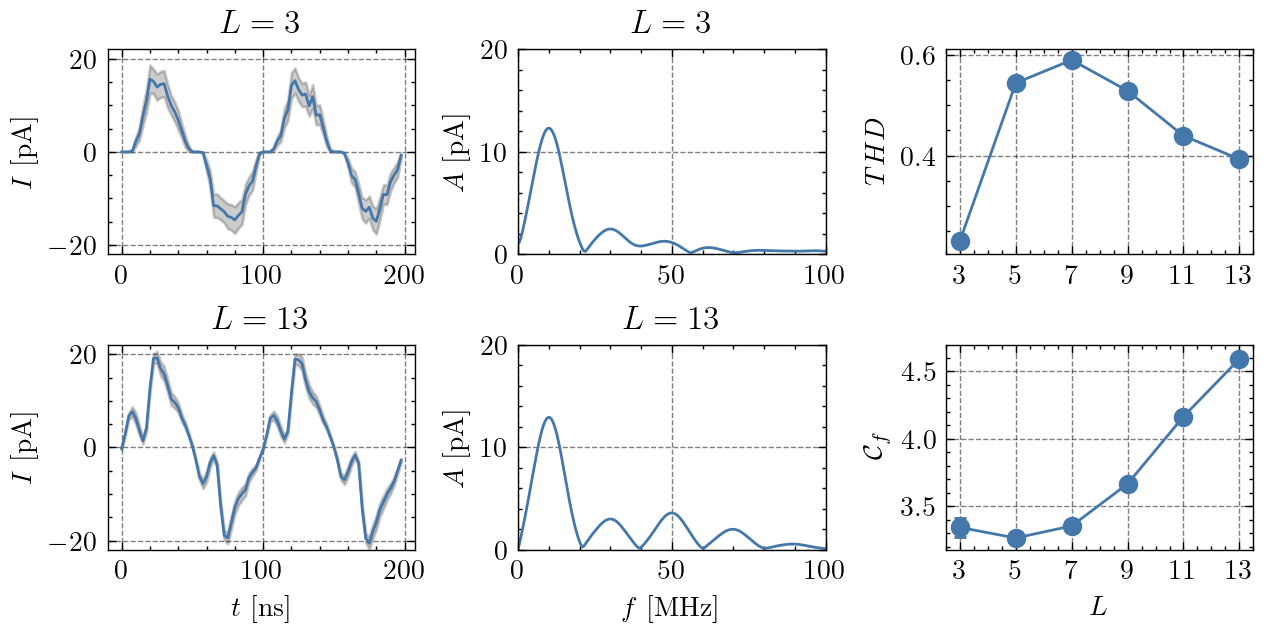

In [389]:
N_PLOT  = 2
L1      = 3
L2      = 13

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
fig.set_figheight(fig.get_figheight()*1.2)

ax  = fig.add_subplot(2,3,1)
_   = ax.plot(TIME[:SAMPLE_P_PERIOD*N_PLOT], output[L1][:SAMPLE_P_PERIOD*N_PLOT])
_   = ax.fill_between(TIME[:SAMPLE_P_PERIOD*N_PLOT], output[L1][:SAMPLE_P_PERIOD*N_PLOT]-error[L1][:SAMPLE_P_PERIOD*N_PLOT],
                      output[L1][:SAMPLE_P_PERIOD*N_PLOT]+error[L1][:SAMPLE_P_PERIOD*N_PLOT], color='black', alpha=0.2)
_   = ax.set_ylabel("$I$ [pA]")
_   = ax.set_ylim(-22,22)
_   = ax.set_title(f"$L = {L1}$")

ax  = fig.add_subplot(2,3,4)
_   = ax.plot(TIME[:SAMPLE_P_PERIOD*N_PLOT], output[L2][:SAMPLE_P_PERIOD*N_PLOT])
_   = ax.fill_between(TIME[:SAMPLE_P_PERIOD*N_PLOT], output[L2][:SAMPLE_P_PERIOD*N_PLOT]-error[L2][:SAMPLE_P_PERIOD*N_PLOT],
                      output[L2][:SAMPLE_P_PERIOD*N_PLOT]+error[L2][:SAMPLE_P_PERIOD*N_PLOT], color='black', alpha=0.2)
_   = ax.set_ylabel("$I$ [pA]")
_   = ax.set_xlabel("$t$ [ns]")
_   = ax.set_ylim(-22,22)
_   = ax.set_title(f"$L = {L2}$")

ax      = fig.add_subplot(2,3,2)
xf, yf  = get_frequency_spectrum(output[L1][:SAMPLE_P_PERIOD*N_PLOT], dt=DT, pad_len=4096)
_       = ax.plot(xf*1e-6, yf)
_       = ax.set_ylabel("$A$ [pA]")
_       = ax.set_ylim(0.0,20)
_       = ax.set_xlim(0,100)
# _       = ax.set_yscale('log')
_       = ax.set_title(f"$L = {L1}$")

ax      = fig.add_subplot(2,3,5)
xf, yf  = get_frequency_spectrum(output[L2][:SAMPLE_P_PERIOD*N_PLOT], dt=DT, pad_len=4096)
_       = ax.plot(xf*1e-6, yf)
_       = ax.set_ylim(0.0,20)
# _       = ax.set_yscale('log')
_       = ax.set_xlabel("$f$ [MHz]")
_       = ax.set_ylabel("$A$ [pA]")
_       = ax.set_xlim(0,100)
_       = ax.set_title(f"$L = {L2}$")

ax      = fig.add_subplot(2,3,3)
_       = ax.errorbar(N_PARTICLES, np.mean(thd_vals,axis=1), 1.96*np.std(thd_vals,axis=1), marker='o', capsize=2)
_       = ax.set_ylabel("$THD$")
_       = ax.set_xticks(N_PARTICLES)

ax      = fig.add_subplot(2,3,6)
_       = ax.errorbar(N_PARTICLES, np.mean(cf_vals,axis=1), 1.96*np.std(cf_vals,axis=1), marker='o', capsize=2)
_       = ax.set_ylabel("$\mathcal{C}_f$")
_       = ax.set_xlabel("$L$")
_       = ax.set_xticks(N_PARTICLES)

fig.savefig("plots/png/current_response_comparison.png", transparent=False)
fig.savefig("plots/svg/current_response_comparison.svg", transparent=True)
fig.savefig("plots/pdf/current_response_comparison.pdf", transparent=False)

In [289]:
pot_thd_vals = [np.array([compute_thd(extract_harmonic_features(pots[N][:,i],n_vals,mode='abs',pad_len=4096)) for i in range(N*N)]).reshape(N,N) for N in N_PARTICLES]
pot_cf_vals  = [np.array([compute_spectral_centroid(extract_harmonic_features(pots[N][:,i],n_vals,mode='abs',pad_len=4096), n_vals) for i in range(N*N)]).reshape(N,N) for N in N_PARTICLES]

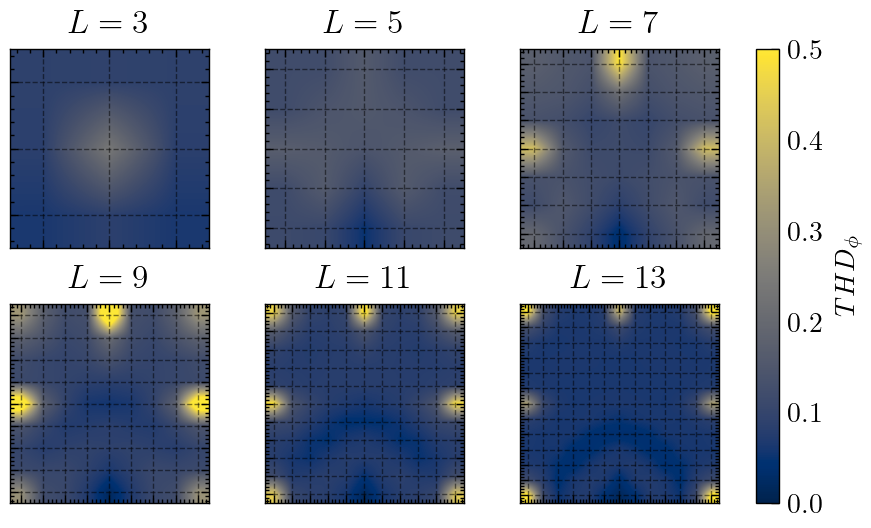

In [382]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.3)
axs =  []
for i, N in enumerate(N_PARTICLES):
    ax = fig.add_subplot(2,3,i+1)
    im = ax.imshow(pot_thd_vals[i], vmin=0, vmax=0.5, origin='lower', interpolation='bilinear', cmap='cividis')
    _  = ax.set_xticks(np.arange(N))
    _  = ax.set_yticks(np.arange(N))
    _  = ax.set_xticklabels("")
    _  = ax.set_yticklabels("")
    _  = ax.set_title(f"$L = {N}$")
    axs.append(ax)

cb = fig.colorbar(im, ax=axs, shrink=1.0, label='$THD_\phi$')

fig.savefig("plots/png/spatical_THD_pot_dist_vs_size.png", transparent=False)
fig.savefig("plots/svg/spatical_THD_pot_dist_vs_size.svg", transparent=True)
fig.savefig("plots/pdf/spatical_THD_pot_dist_vs_size.pdf", transparent=False)

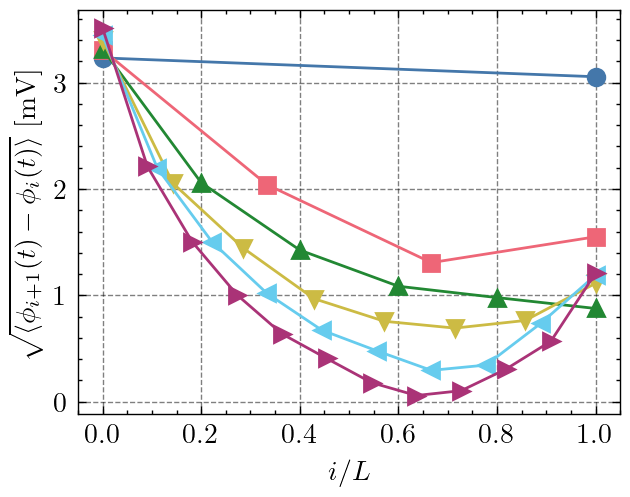

In [388]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
mss = ['o','s','^','v','<','>']
for i, N in enumerate(N_PARTICLES):
    _ = ax.plot(np.arange(N-1)/(N-2), np.sqrt(np.mean(np.diff(pots[N].reshape(800,N,N)[:SAMPLE_P_PERIOD//2,:,:],axis=1)**2,axis=0))[:,N//2]*1000, marker=mss[i])
_ = ax.set_xlabel("$i/L$")
_ = ax.set_ylabel("$\sqrt{\langle\phi_{i+1}(t) - \phi_{i}(t)\\rangle}~[\mathrm{mV}]$")

fig.savefig("plots/png/volt_drop_input_to_output.png", transparent=False)
fig.savefig("plots/svg/volt_drop_input_to_output.svg", transparent=True)
fig.savefig("plots/pdf/volt_drop_input_to_output.pdf", transparent=False)